In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.pipeline import Pipeline
import numpy as np


# Load your data into a DataFrame
df = pd.read_csv('data/food_crises_updated.csv')



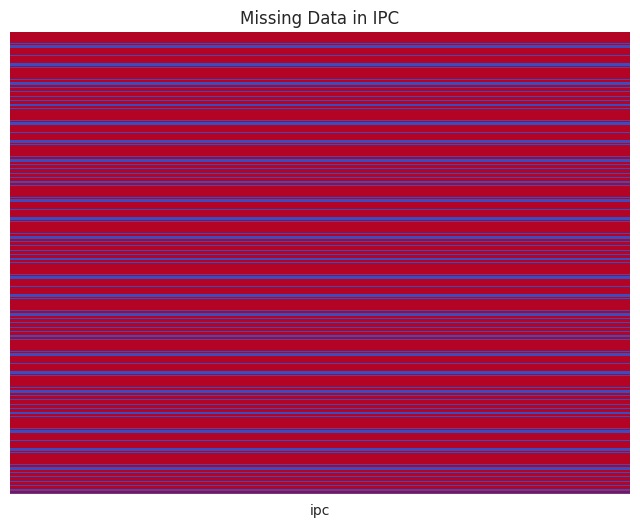

In [2]:


# Create a missing data heatmap for the column of interest using the 'coolwarm' colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['ipc']].isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
plt.title('Missing Data in IPC')
plt.show()


In [3]:
# Calculate summary statistics for the column with missing data
summary_stats = df[['ipc']].describe()

# Compare statistics for missing and non-missing values
summary_stats_missing = df[df['ipc'].isnull()][['ipc']].describe()
summary_stats_not_missing = df[~df['ipc'].isnull()][['ipc']].describe()

print("Summary statistics for missing values:")
print(summary_stats_missing)

print("\nSummary statistics for non-missing values:")
print(summary_stats_not_missing)


Summary statistics for missing values:
       ipc
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN

Summary statistics for non-missing values:
               ipc
count  3042.000000
mean      2.124918
std       0.896948
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000


In [4]:
# Calculate correlations with other columns
correlation_matrix = df.corr()

# Extract the correlation with the column of interest
correlation_with_column = correlation_matrix['ipc']

print("Correlation with other columns:")
print(correlation_with_column)


Correlation with other columns:
district_code      0.232751
centx              0.084513
centy              0.246221
year               0.612337
month              0.021450
ipc                1.000000
ha                 0.158948
ndvi_mean         -0.021316
ndvi_anom          0.208910
rain_mean          0.007412
rain_anom          0.086770
et_mean           -0.055851
et_anom            0.068227
count_violence     0.121199
sum_fatalities     0.042918
food_price_idx     0.553037
area              -0.014956
cropland_pct      -0.006450
pop                0.077619
ruggedness_mean   -0.151872
pasture_pct        0.321639
Name: ipc, dtype: float64


In [5]:
# CALCULATE THE CORRELATION FOR GREATER UPPER NILE
# Filter the DataFrame for the selected region
great_up = df[df['administrative_region'] == 'Greater Upper Nile']

# Calculate the correlation matrix for the selected data
correlation_matrix = great_up.corr()

correlation_matrix['ipc']

district_code     -0.073789
centx             -0.099228
centy             -0.131567
year               0.636702
month              0.036787
ipc                1.000000
ha                 0.014138
ndvi_mean          0.159314
ndvi_anom          0.283401
rain_mean          0.155415
rain_anom          0.145341
et_mean            0.099447
et_anom            0.082940
count_violence     0.100809
sum_fatalities     0.043597
food_price_idx     0.488236
area               0.020064
cropland_pct      -0.085547
pop                0.155297
ruggedness_mean   -0.050628
pasture_pct        0.153195
Name: ipc, dtype: float64

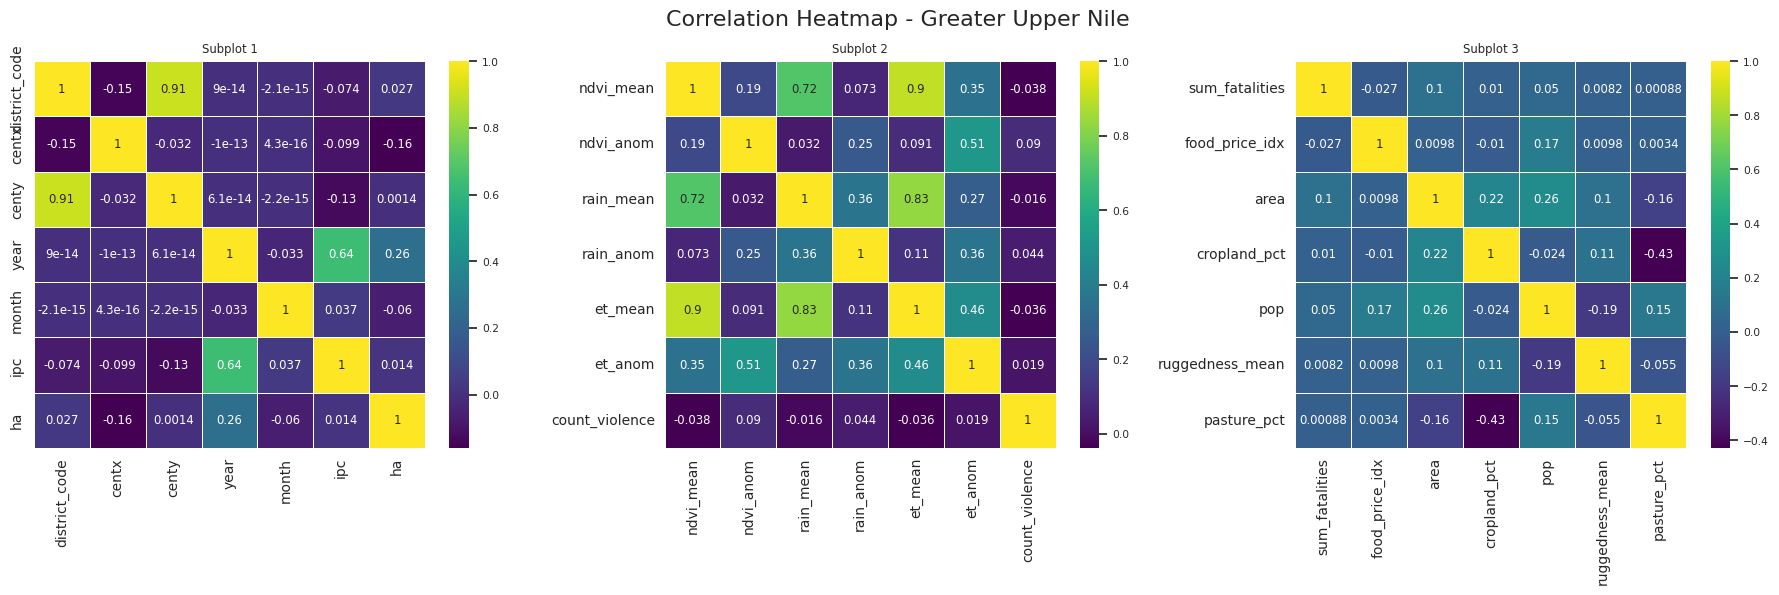

In [6]:
# PLOT THE CORRELATION MATRIX FOR GREATER UPPER NILE
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Greater Upper Nile', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# CALCULATE THE CORRELATION FOR Bahr El Ghazal
# Filter the DataFrame for the selected region
bahr_el = df[df['administrative_region'] == 'Bahr El Ghazal']

# Calculate the correlation matrix for the selected data
correlation_matrix = bahr_el.corr()

correlation_matrix['ipc']

district_code      0.076627
centx             -0.075184
centy              0.169134
year               0.633606
month              0.036800
ipc                1.000000
ha                 0.180086
ndvi_mean          0.086325
ndvi_anom          0.124932
rain_mean          0.158888
rain_anom          0.129263
et_mean            0.078412
et_anom            0.114314
count_violence     0.091983
sum_fatalities    -0.047433
food_price_idx     0.602395
area              -0.067577
cropland_pct       0.146773
pop                0.234691
ruggedness_mean   -0.109764
pasture_pct        0.123272
Name: ipc, dtype: float64

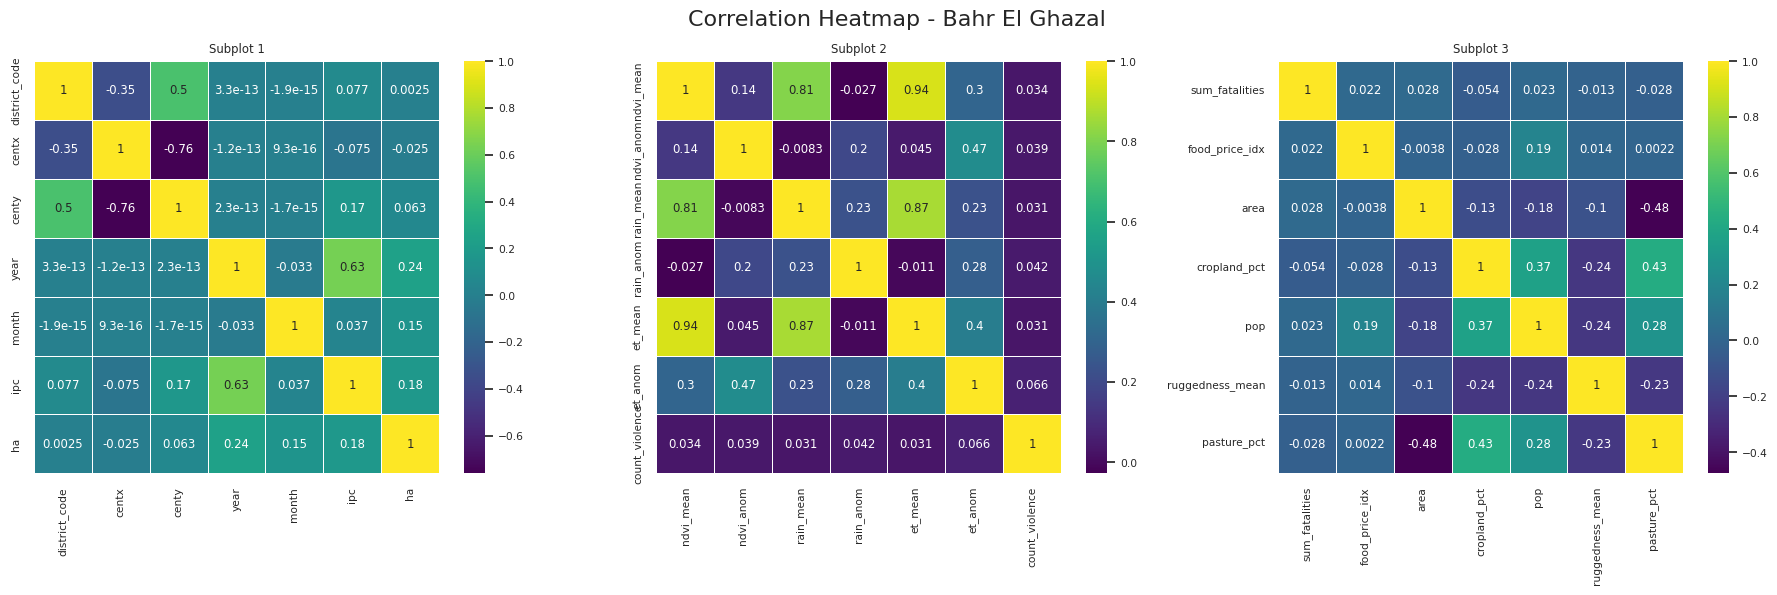

In [8]:
# PLOT THE CORRELATION MATRIX FOR Bahr El Ghazal
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Bahr El Ghazal', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# CALCULATE THE CORRELATION FOR Equatoria
# Filter the DataFrame for the selected region
equatoria = df[df['administrative_region'] == 'Equatoria']

# Calculate the correlation matrix for the selected data
correlation_matrix = equatoria.corr()

correlation_matrix['ipc']

district_code      0.076613
centx              0.311179
centy             -0.041526
year               0.664034
month             -0.010740
ipc                1.000000
ha                 0.160484
ndvi_mean         -0.148691
ndvi_anom          0.122580
rain_mean         -0.110516
rain_anom          0.009112
et_mean           -0.105088
et_anom            0.038208
count_violence     0.186081
sum_fatalities     0.151902
food_price_idx     0.700130
area               0.073100
cropland_pct       0.213106
pop                0.164045
ruggedness_mean    0.051495
pasture_pct        0.266323
Name: ipc, dtype: float64

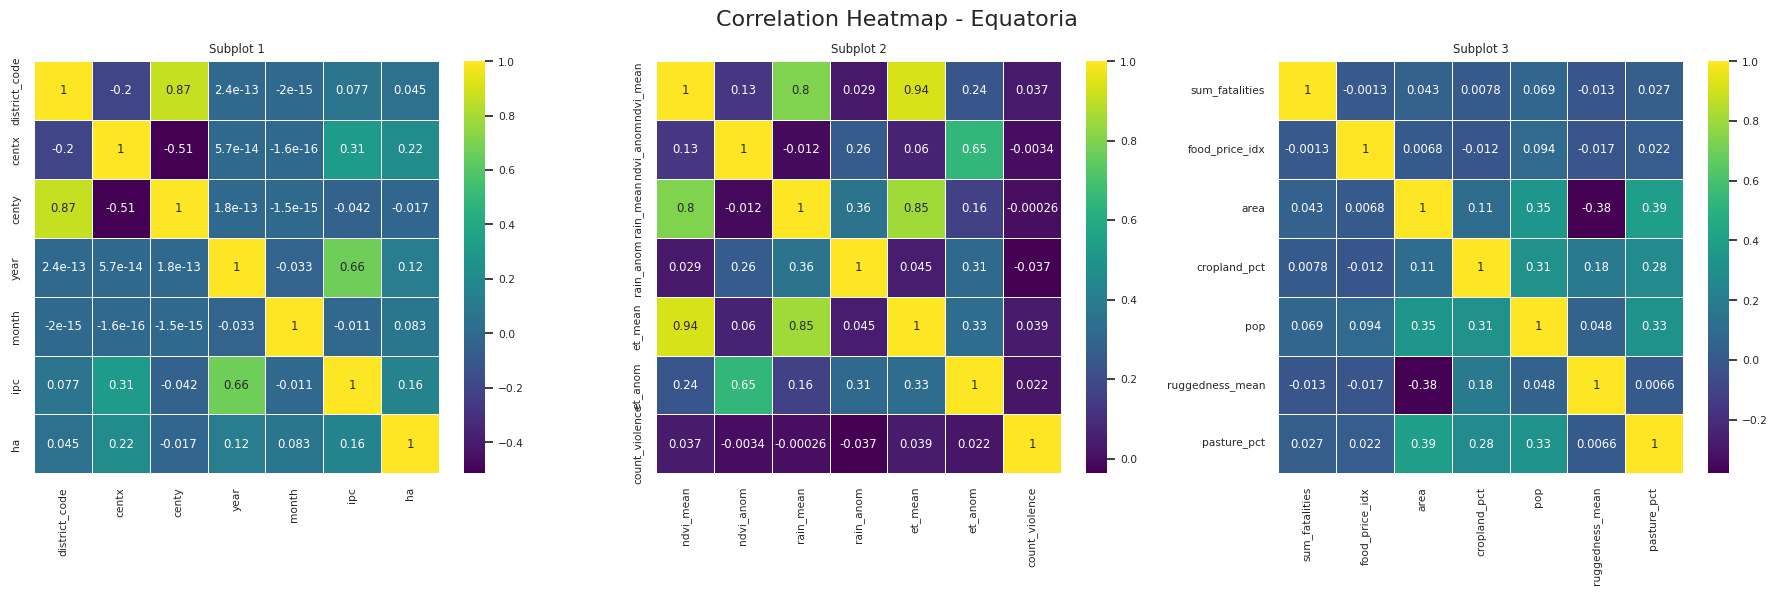

In [10]:
# PLOT THE CORRELATION MATRIX FOR Equatoria
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Equatoria', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:


# Split 'year_month' into 'year' and 'month' columns
df['year'] = df['year_month'].str.split('_').str[0].astype(int)
df['month'] = df['year_month'].str.split('_').str[1].astype(int)

# Define a reference date (e.g., '2007-01-01' for the first day of the first month)
reference_date = datetime.datetime(2007, 1, 1)

# Calculate the number of months since the reference date
df['year_month_numeric'] = (df['year'] - reference_date.year) * 12 + (df['month'] - reference_date.month)


# Create a binary indicator variable for missingness in the column of interest
df['missing_indicator'] = df['ipc'].isnull().astype(int)

# Fit a logistic regression model to predict the missingness
model = sm.Logit(df['missing_indicator'], sm.add_constant(df[['year_month_numeric']]))  # Add other relevant variables
results = model.fit()

# Perform Little's MCAR test
mcar_test = results.prsquared
print("Little's MCAR Test p-value:", mcar_test)



Optimization terminated successfully.
         Current function value: 0.549511
         Iterations 5
Little's MCAR Test p-value: 0.016679300591537882


In [6]:
# Calculate the percentage of missing values for the column of interest
missing_percentage = (df['ipc'].isnull().sum() / len(df)) * 100
print(f"Percentage of missing values in ipc: {missing_percentage:.2f}%")


Percentage of missing values in ipc: 75.32%


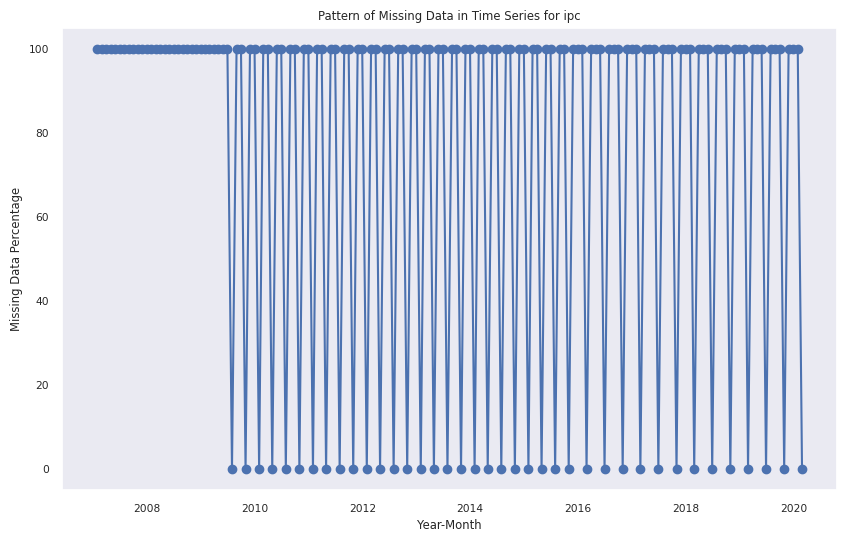

In [12]:
# Create a sample DataFrame with mixed date formats
data = {'year_month': ['2007-01-01', '2007-02-01', '2007-03-01', '2007_04', '2007_05', '2007_06'],
        'ipc': [1, 2, 3, 4, 5, 6]}

df1 = pd.DataFrame(data)

# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
df['datetime'] = df['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
df.set_index('datetime', inplace=True)

# Calculate the missing data percentage for each time point
missing_data_percentage = df['ipc'].isnull().astype(int).resample('M').mean() * 100

# Plot the missing data percentage over time (monthly)
plt.figure(figsize=(10, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc')
plt.grid()
plt.show()

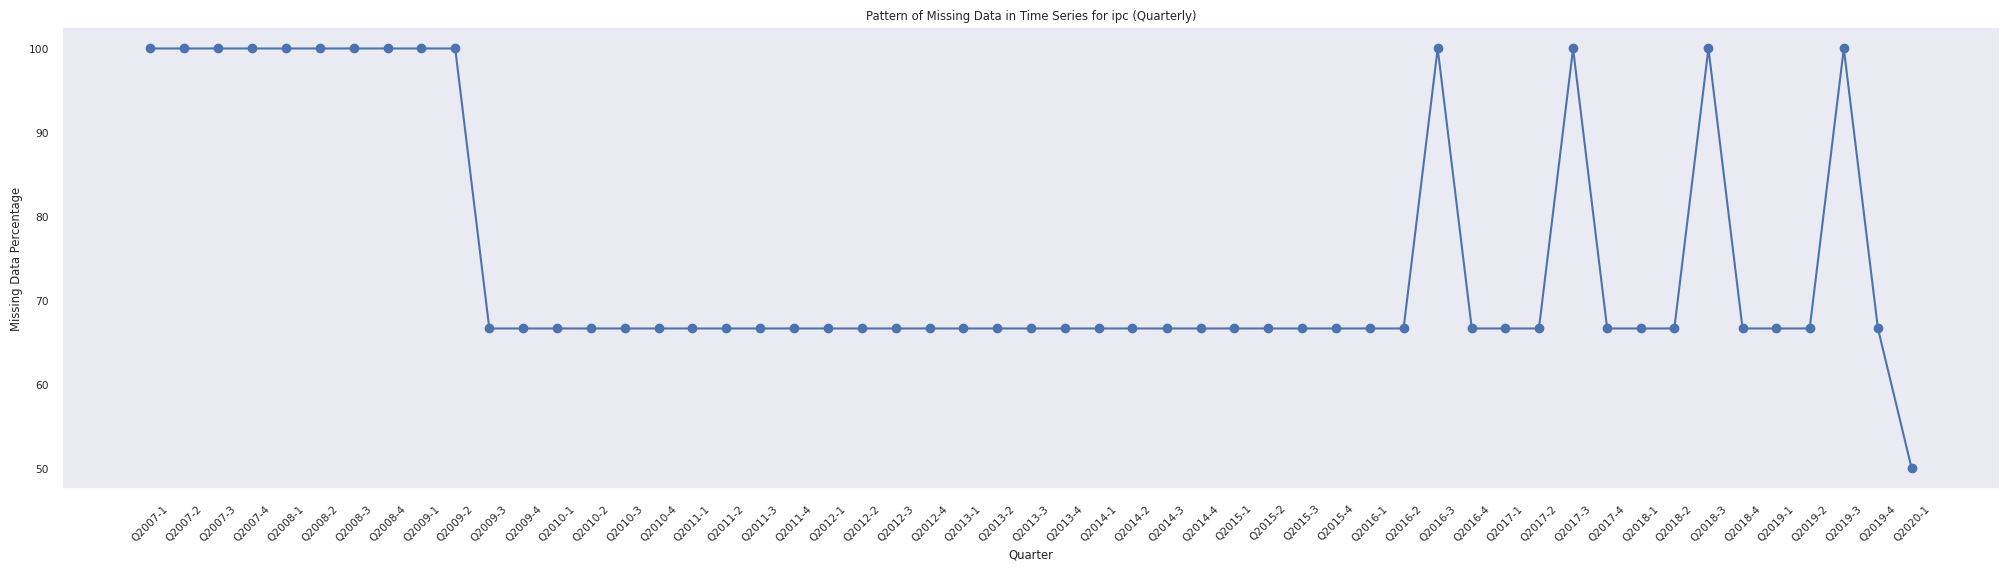

In [13]:

# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
df['quarter'] = df['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
df.set_index('quarter', inplace=True)

# Calculate the missing data percentage for each quarter
missing_data_percentage = df['ipc'].isnull().astype(int).resample('Q').mean() * 100
quarters = [f'Q{quarter.year}-{quarter.quarter}' for quarter in missing_data_percentage.index]

# Plot the missing data percentage over time (quarterly)
plt.figure(figsize=(25, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xticks(missing_data_percentage.index, quarters, rotation=45)  # Set custom x-labels and rotate for readability
plt.xlabel('Quarter')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc (Quarterly)')
plt.grid()
plt.show()


In [15]:
# MULTIPLE IMPUTATION 
trial = pd.read_csv('data/food_crises_updated.csv')


# Create an imputation pipeline
imputation_pipeline = Pipeline([
    ('indicator', MissingIndicator(features="missing-only")),
    ('imputer', IterativeImputer(max_iter=10, random_state=0))
])

# Perform multiple imputations (e.g., 5 imputations)
n_imputations = 10
imputed_datasets = []

for i in range(n_imputations):
    imputed_data = imputation_pipeline.fit_transform(trial['ipc'].values.reshape(-1, 1))
    imputed_datasets.append(imputed_data)

# imputed_datasets now contains the multiple imputed datasets


In [16]:
# Combine imputed datasets (e.g., take the mean)
combined_data = sum(imputed_datasets) / n_imputations  # Take the mean of the imputed datasets

combined_data

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]])

In [17]:
# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
trial['datetime'] = trial['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
trial.set_index('datetime', inplace=True)

test = trial['ipc'].backfill()

test

datetime
2007-01-01    2.0
2007-02-01    2.0
2007-03-01    2.0
2007-04-01    2.0
2007-05-01    2.0
             ... 
2019-10-01    3.0
2019-11-01    4.0
2019-12-01    4.0
2020-01-01    4.0
2020-02-01    4.0
Name: ipc, Length: 12324, dtype: float64

In [18]:
test2 = trial['ipc'].ffill()

test2

datetime
2007-01-01    NaN
2007-02-01    NaN
2007-03-01    NaN
2007-04-01    NaN
2007-05-01    NaN
             ... 
2019-10-01    3.0
2019-11-01    3.0
2019-12-01    3.0
2020-01-01    3.0
2020-02-01    4.0
Name: ipc, Length: 12324, dtype: float64

In [19]:
test3 = trial['ipc'].interpolate(method='linear')

test3

datetime
2007-01-01     NaN
2007-02-01     NaN
2007-03-01     NaN
2007-04-01     NaN
2007-05-01     NaN
              ... 
2019-10-01    3.00
2019-11-01    3.25
2019-12-01    3.50
2020-01-01    3.75
2020-02-01    4.00
Name: ipc, Length: 12324, dtype: float64

MAXIMUM LIKELIHOOD ESTIMATION OF IPC

In [27]:
from scipy.stats import norm

test4 = trial

distribution = norm

observed_data = test4['ipc'].dropna()  # Remove missing values
params = distribution.fit(observed_data)

mean_estimate = (params[0])  # Get the estimated mean
test4['ipc'].fillna(mean_estimate, inplace=True)

test4['ipc'] = test4['ipc'].round()

test4['ipc']

datetime
2007-01-01    2.0
2007-02-01    2.0
2007-03-01    2.0
2007-04-01    2.0
2007-05-01    2.0
             ... 
2019-10-01    3.0
2019-11-01    2.0
2019-12-01    2.0
2020-01-01    2.0
2020-02-01    4.0
Name: ipc, Length: 12324, dtype: float64

Expectation-Maximization (EM) Algorithm

In [28]:
df2 = trial
# Define the number of iterations for the EM algorithm
max_iterations = 100
tolerance = 1e-6  # Set a tolerance level for convergence

# Initialize the missing values with the mean of the observed values
observed_data = df2['ipc'].dropna()
mean_estimate = observed_data.mean()
df2['ipc'].fillna(mean_estimate, inplace=True)

# Perform the EM algorithm
for iteration in range(max_iterations):
    # E-step: Estimate the missing values based on the current parameter estimates
    missing_indices = df2['ipc'].isna()
    observed_values = df2.loc[~missing_indices, 'ipc']
    params = norm.fit(observed_values)
    df2.loc[missing_indices, 'ipc'] = params[0]  # Update missing values with the mean

    # M-step: Re-estimate the parameters of the distribution
    observed_values = df2['ipc'].dropna()
    new_params = norm.fit(observed_values)

    # Check for convergence
    if np.abs(params[0] - new_params[0]) < tolerance:
        break

print("EM Algorithm Converged after", iteration + 1, "iterations.")


EM Algorithm Converged after 1 iterations.


In [29]:
df2['ipc']

datetime
2007-01-01    2.0
2007-02-01    2.0
2007-03-01    2.0
2007-04-01    2.0
2007-05-01    2.0
             ... 
2019-10-01    3.0
2019-11-01    2.0
2019-12-01    2.0
2020-01-01    2.0
2020-02-01    4.0
Name: ipc, Length: 12324, dtype: float64

In [30]:
# Check if values in the 'ipc' column are the same
are_values_equal = (test4['ipc'] == df2['ipc']).all()

if are_values_equal:
    print("Values in ipc column are the same in both DataFrames.")
else:
    print("Values in ipc column are not the same in both DataFrames.")


Values in ipc column are the same in both DataFrames.


Bayesian Methods with library PyMC3 - gives error

In [46]:
import pymc3 as pm




ImportError: cannot import name 'local_bitwidth' from 'theano.configdefaults' (/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/theano/configdefaults.py)

In [ ]:
b = trial

with pm.Model() as model:
    # Define a prior distribution for the missing values
    mu = pm.Normal('mu', mu=0, sd=10)  # You can adjust the prior as needed
    
    # Define likelihood for observed and missing values
    observed_data = b['ipc'].dropna()
    missing_indices = b['ipc'].isna()
    
    observed_values = pm.Normal('observed_values', mu=mu, sd=1, observed=observed_data)
    missing_values = pm.Normal('missing_values', mu=mu, sd=1, shape=len(missing_indices))

with model:
    trace = pm.sample(1000, tune=1000, chains=1)  # Adjust as needed
    imputed_missing_values = pm.sample_posterior_predictive(trace)['missing_values']
    df.loc[missing_indices, 'ipc'] = imputed_missing_values[0]

b['ipc']

Bayesian Methods with library PyStan

In [75]:
import stan
import nest_asyncio
nest_asyncio.apply()

c = trial

# Extract observed 'ipc' values and missing value indices
observed_ipc = df['ipc'].dropna().values
missing_indices = df.index[df['ipc'].isna()].tolist()

stan_code = """
data {
    int<lower=0> N;               // Number of observations
    real observed_ipc[N];        // Observed 'ipc' values
    int<lower=0> N_missing;      // Number of missing values
}

parameters {
    real mu;                      // Prior mean for 'ipc'
    real<lower=0> sigma;          // Prior standard deviation for 'ipc'
    real ipc_missing[N_missing];  // Missing 'ipc' values
}

model {
    // Priors for 'ipc'
    mu ~ normal(0, 10);  // Adjust the prior mean and standard deviation as needed
    sigma ~ normal(0, 1);

    // Likelihood for observed 'ipc'
    observed_ipc ~ normal(mu, sigma);

    // Likelihood for missing 'ipc'
    for (i in 1:N_missing) {
        ipc_missing[i] ~ normal(mu, sigma);
    }
}
"""

# Compile the Stan model
model = stan.build(stan_code)

# Prepare the data for Stan
stan_data = {
    'N_observed': len(observed_data),
    'observed_values': observed_data,
    'N_missing': len(missing_indices)
}

# Run the Stan model and impute missing values
fit = model.sampling(data=stan_data, iter=1000, chains=4)  # Adjust as needed
imputed_missing_values = fit.extract()['missing_values'][0]
c.loc[missing_indices, 'ipc'] = imputed_missing_values

c['ipc']

Building...

/home/julia/.cache/httpstan/4.10.1/models/qkh7ti4w/model_qkh7ti4w.cpp: In constructor ‘model_qkh7ti4w_namespace::model_qkh7ti4w::model_qkh7ti4w(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/julia/.cache/httpstan/4.10.1/models/qkh7ti4w/model_qkh7ti4w.cpp:47:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   47 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/httpstan/include/stan/math/


Building: 14.0s, done.Messages from stanc:
Warning in '/tmp/httpstan_sgin66i8/model_qkh7ti4w.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_sgin66i8/model_qkh7ti4w.stan', line 11, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


RuntimeError: Error calling get_param_names: `Exception: variable does not exist; processing stage=data initialization; variable name=N; base type=int (in '/tmp/httpstan_6ka51vrt/model_qkh7ti4w.stan', line 3, column 4 to column 19)`

In [77]:
# Check if values in the 'ipc' column are the same
are_values_equal = (test4['ipc'] == c['ipc']).all()

if are_values_equal:
    print("Values in ipc column are the same in both DataFrames.")
else:
    print("Values in ipc column are not the same in both DataFrames.")


Values in ipc column are the same in both DataFrames.


SO FAR THE VALUES OBTAINED FROM BAYESIAN APPROACH, EM ALGORITHM, AND MLE ARE THE SAME.

In [81]:
nan_count = c['ipc'].isna().sum()
print('There are ' + f'{nan_count}' + ' NaN values after performing Bayesian approach, EM, or MLE.')

There are 0 NaN values after performing Bayesian approach, EM, or MLE.


In [79]:
# Calculate summary statistics for the column with missing data
sum_stats = c[['ipc']].describe()

sum_stats

,ipc
count,12324.000000
mean,2.030834
std,0.448815
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,5.000000
